<a href="https://colab.research.google.com/github/RobinBargen/General/blob/main/MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

**Downloading the MNIST dataset**

The MNIST dataset contains of 60,000 28x28 grayscale images. Each image in the MNIST dataset depicts a handwritten numeral from 0 to 9.

The below code imports the MNIST dataset. It downloads one training set and one test set, that will be used to train and evaluate our model.

In [6]:
training_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



**Visualising the data**

The following code defines the class labels and displays some random images in the dataset.

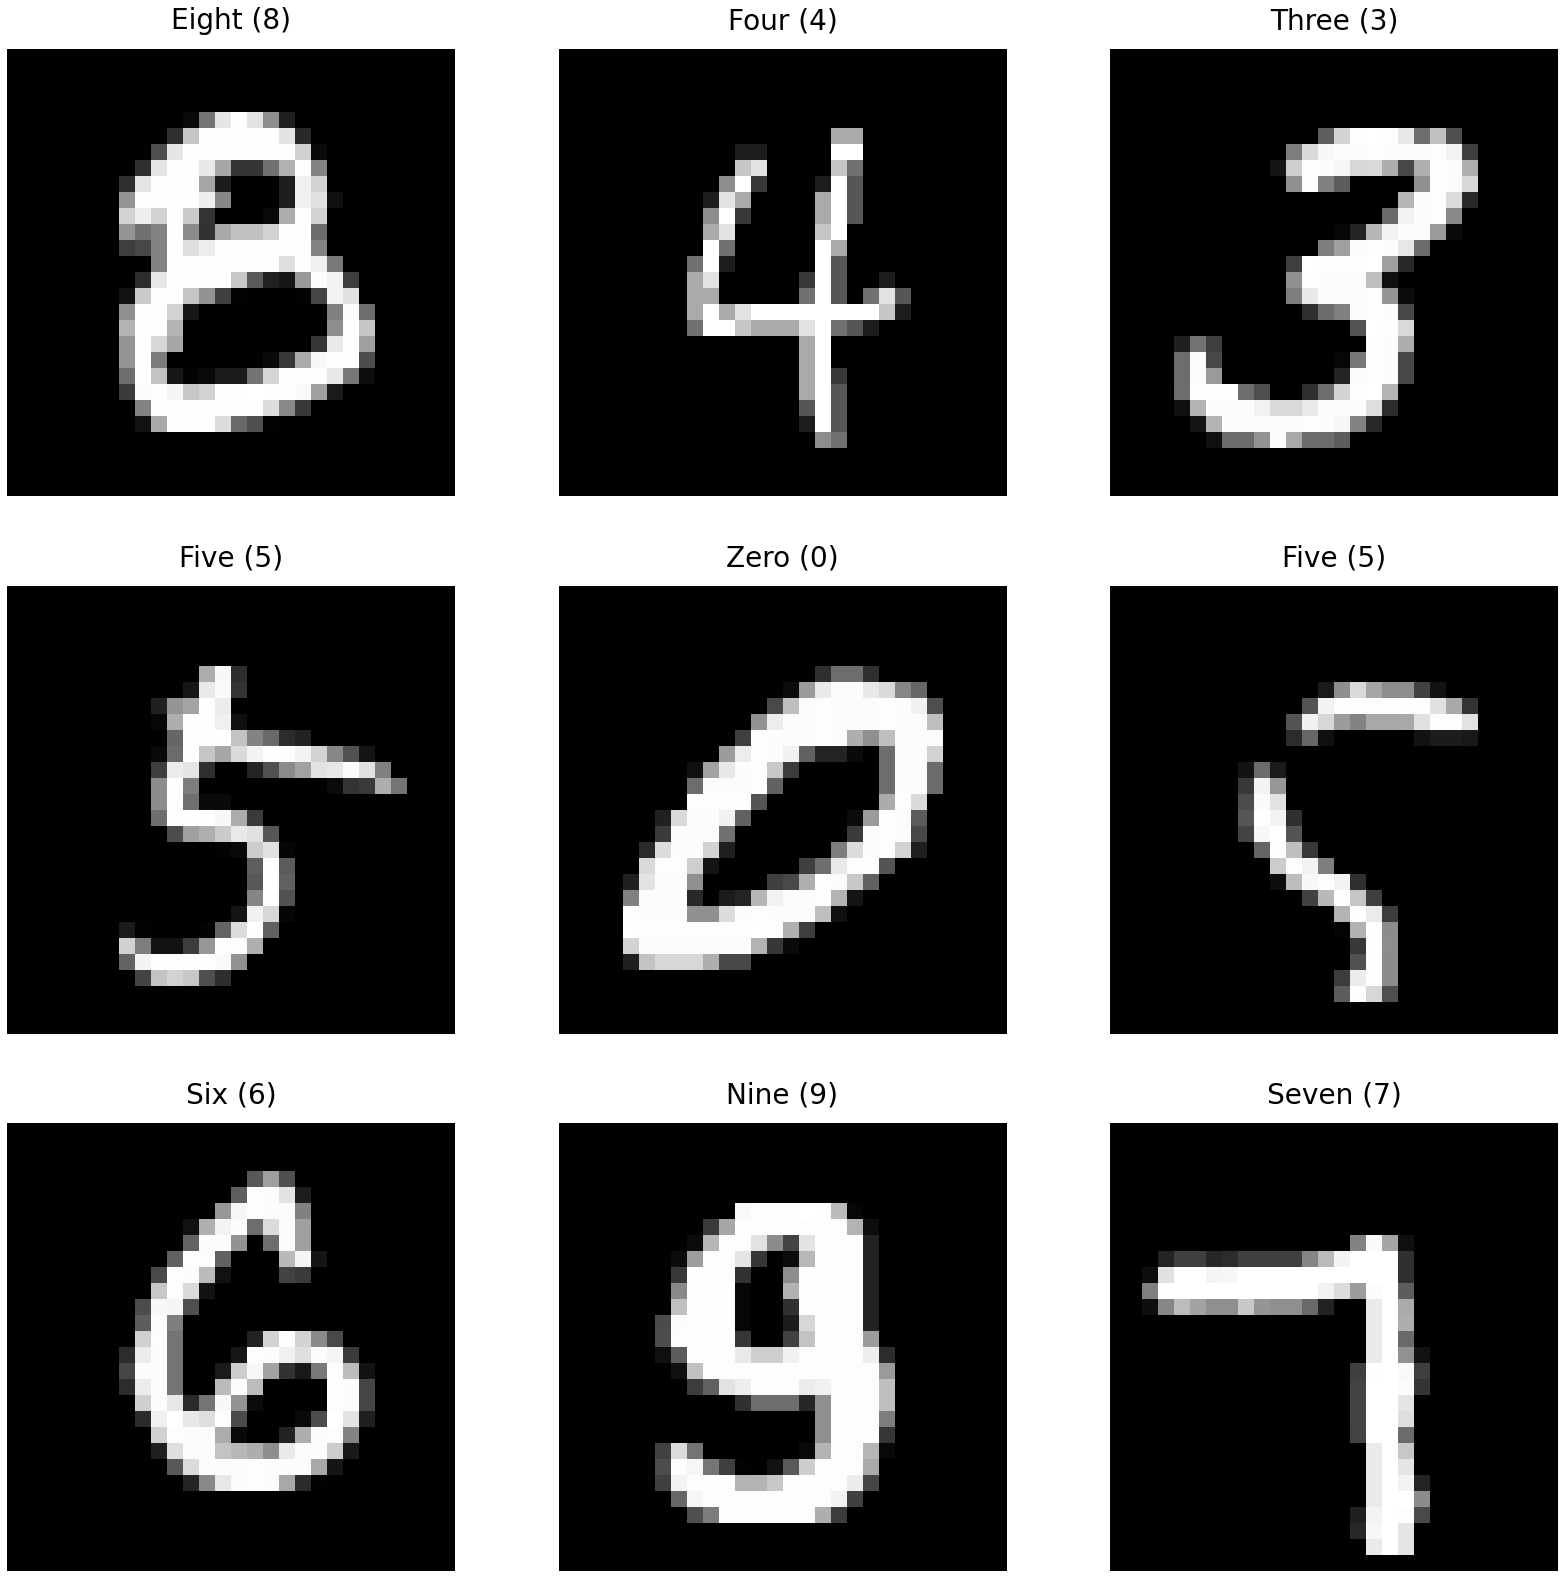

In [7]:
# define labels
class_labels = {
    0: "Zero (0)",
    1: "One (1)",
    2: "Two (2)",
    3: "Three (3)",
    4: "Four (4)",
    5: "Five (5)",
    6: "Six (6)",
    7: "Seven (7)",
    8: "Eight (8)",
    9: "Nine (9)"
}

# define length of training data
training_length = len(training_data)

# display images
rows = 3
columns = 3
figure = plt.figure(figsize=(28, 28))
number_of_display_images = rows * columns

for i in range(1, number_of_display_images + 1):
  sample_index = torch.randint(training_length, size=(1,)).item()
  image, label = training_data[sample_index]
  class_label = class_labels[label]
  figure.add_subplot(rows, columns, i)
  plt.title(class_label, fontsize=28, pad=20)
  plt.axis("off")
  plt.imshow(image.squeeze(), cmap="gray")
plt.show()

  



**Building the neural network**

The following section defines the neural network model that will be used to classify handwritten digits.

In [14]:
"""
=================================================================
Class: Neural Network                                         
                                                             
Description: 
Define Neural Network model to classify 28 x 28 images
based upon the MNIST dataset.
=================================================================
"""
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    image_width, image_height = 28, 28
    layer1_output_size = 128                
    layer2_output_size = 10
    self.flatten = nn.Flatten()
    self.network_model = nn.Sequential(
        nn.Linear(image_width*image_height, layer1_output_size),
        nn.ReLU(),
        nn.Linear(layer1_output_size, layer2_output_size)
    )

  """
  function 'forward' is triggered automatically once 
  the class object is called upon with some input data, 'x'.
  """
  def forward(self, x):
    x = self.flatten(x)
    logits = self.network_model(x)
    return logits

**Initialising model**

Having defined the model, it can now be applied to our classification problem.

In [15]:
# load the dataset
training_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# init hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 5

# init model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)

# Print model info
print(device)
print(model)

cpu
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network_model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


To train the model a training loop and a test/validation loop is required. Here we use the standard loop suggested by the pytorch - documentation.

In [16]:
"""
=================================================================
Name: training_loop

Description:
The function defines a training loop. The training loop serves 
the purpose of optimising the network when the model is trained. 
This is done by iterating over the training set and itteratively 
trying to optimise the model parameters.
=================================================================
"""
def training_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



"""
=================================================================
Name: validation_loop

Description:
The function defines a validation/test loop. The validation loop
iterates over the dataset and checks the accuracy of the 
predictions. 
=================================================================
"""
def validation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy_stats = f"Test Error: \nAccuracy: {(100*correct):>0.1f}%"
    loss_stats = f"Avg loss: {test_loss:>8f}"
    print(accuracy_stats + "\t" + loss_stats + "\n")

Finally, the model is deployed to the classification problem. The accuracy is monitored for each epoch.

In [17]:
# define loss function and optimiser
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# train the model
print("Start training...")
for t in range(epochs):
  print(f"\nEpoch {t+1}\n" + "-"*30)
  training_loop(training_dataloader, model, loss_function, optimizer)
  validation_loop(test_dataloader, model, loss_function)
print("Finished training!")

Start training...

Epoch 1
------------------------------
loss: 2.301414  [   64/60000]
loss: 2.293578  [ 6464/60000]
loss: 2.269516  [12864/60000]
loss: 2.264882  [19264/60000]
loss: 2.223666  [25664/60000]
loss: 2.210899  [32064/60000]
loss: 2.195440  [38464/60000]
loss: 2.207457  [44864/60000]
loss: 2.161436  [51264/60000]
loss: 2.135854  [57664/60000]
Test Error: 
Accuracy: 59.9%	Avg loss: 2.128096


Epoch 2
------------------------------
loss: 2.134416  [   64/60000]
loss: 2.112036  [ 6464/60000]
loss: 2.091674  [12864/60000]
loss: 2.037434  [19264/60000]
loss: 2.014110  [25664/60000]
loss: 1.995587  [32064/60000]
loss: 1.950266  [38464/60000]
loss: 2.011853  [44864/60000]
loss: 1.918929  [51264/60000]
loss: 1.872011  [57664/60000]
Test Error: 
Accuracy: 73.3%	Avg loss: 1.864196


Epoch 3
------------------------------
loss: 1.877796  [   64/60000]
loss: 1.824839  [ 6464/60000]
loss: 1.834092  [12864/60000]
loss: 1.717753  [19264/60000]
loss: 1.722328  [25664/60000]
loss: 1.696678

** Visualising the results **

Having trained the model we may attempt to predict a couple of random sample images and visualise the results.

<Figure size 2016x2016 with 0 Axes>

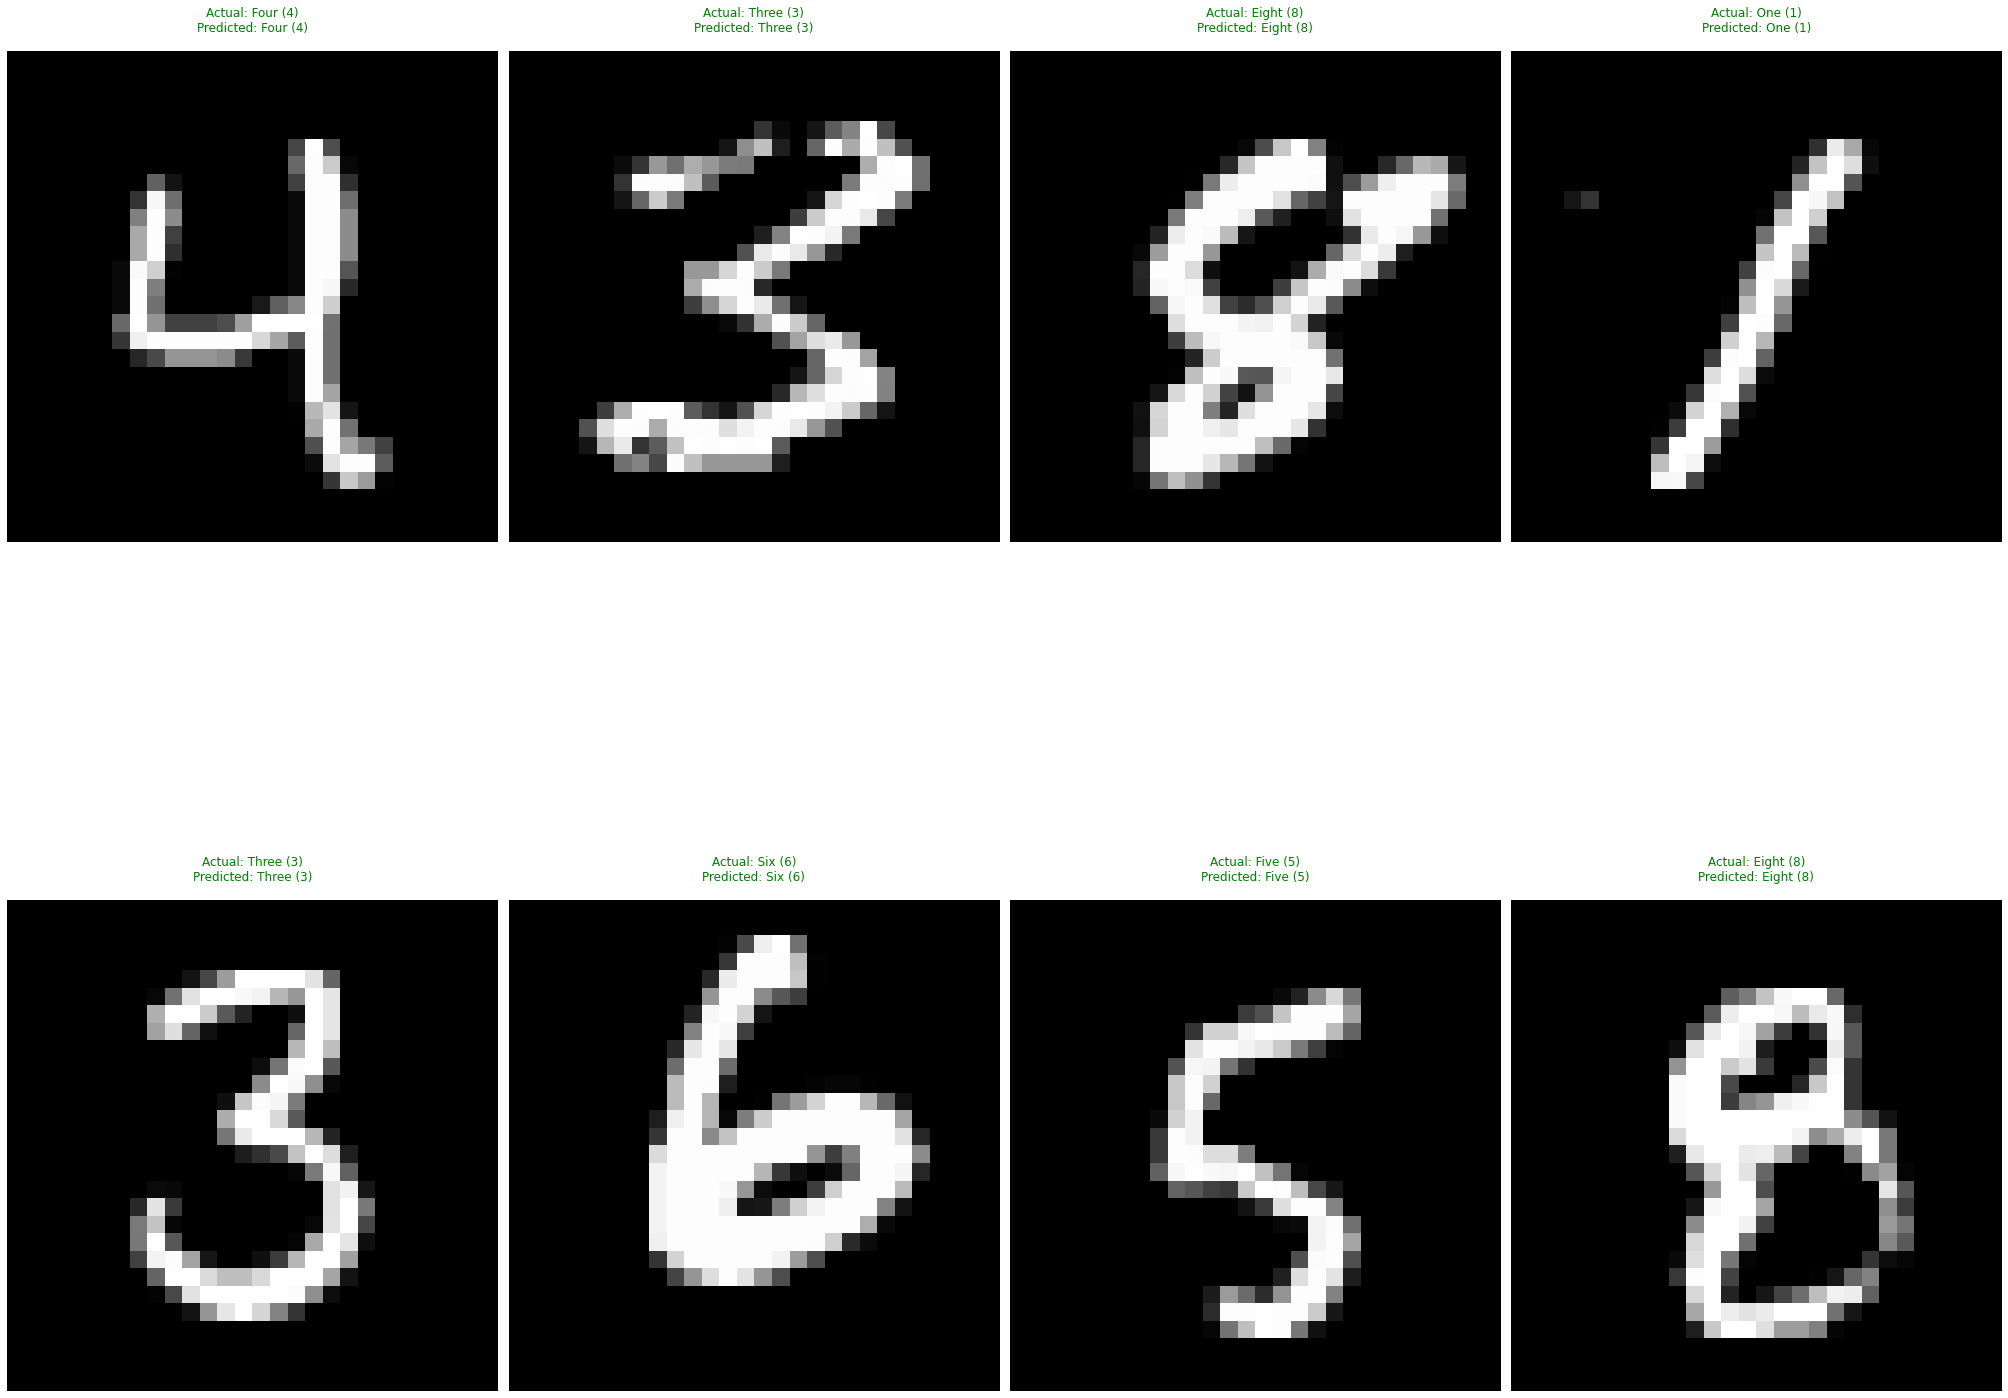

In [56]:
test_length = len(test_data)

rows = 2
columns = 4
figure = plt.figure(figsize=(28, 28))
number_of_display_images = rows * columns

images_to_classify = []
actual_labels = []
predicted_labels = []


# retrieve the predicted class of the first images in the dataset
with torch.no_grad():
  for i in range(1, number_of_display_images + 1):
    sample_index = torch.randint(test_length, size=(1,)).item()
    image, label = test_data[sample_index]

    # classify image
    predicted = model(image)
    argmax_prediction = torch.argmax(predicted).item()

    # sample results
    images_to_classify.append(image)
    actual_labels.append(label)
    predicted_labels.append(argmax_prediction)


# draw figure
figure = plt.figure(figsize=(28, 28))
for i in range(1, number_of_display_images + 1):
  image = images_to_classify[i-1]
  title = "Actual: " +  class_labels[actual_labels[i-1]] + "\nPredicted: "+ class_labels[predicted_labels[i-1]]
  title_color = "green" if (actual_labels[i-1] == predicted_labels[i-1]) else "red"
  
  figure.add_subplot(rows, columns, i)
  plt.title(title, fontsize=12, pad=20, color=title_color)
  plt.axis("off")
  plt.imshow(image.squeeze(), cmap="gray")
plt.tight_layout()
plt.show()

